Python 3.11.7  

In [3]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.models import vgg16
import json
from pycocotools.coco import COCO

import pickle
from tqdm import tqdm
import skimage.io as io
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
# import tqdm as notebook_tqdm
pd.set_option('display.max_colwidth', None)

/home/nnyamkin/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 4080'

In [6]:
# инициализируем этапы предобработки датасета изображений
transform = transforms.Compose([
                                #приводим к нужному размеру
                                transforms.Resize((224,224)),
                                # превращаем изображение в тензор
                                transforms.ToTensor(),                                
                                # transforms.PILToTensor(),
                                # Зачем нужна нормализация???
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],     
                                                     std=[0.229, 0.224, 0.225])])

In [7]:
# train_images = dset.ImageFolder(root = './data/',
#                                 transform = transform)

In [8]:
train_data = dset.CocoCaptions(root = '../data/train2017',
                        annFile = '../data/annotations/captions_train2017.json',
                        transform = transform)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [9]:
# train_images = [img for img, _ in train_data]
# pickle.dump(train_images, open('./pickle_files/coco_images.pickle','wb'))

In [10]:
print('Количество изображений в обучающей выборке: ', len(train_data))

Количество изображений в обучающей выборке:  118287


In [11]:
val_data = dset.CocoCaptions(root = '../data/val2017',
                        annFile = '../data/annotations/captions_val2017.json',
                        transform = transform)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [12]:
print('Количество изображений в валидационной выборке: ', len(val_data))

Количество изображений в валидационной выборке:  5000


In [13]:
def plot_image(image):
    # копирую тензор и превращаю его в numpy массив
    image = image.clone().detach().numpy()
    # меняю местами оси массива: 0 с 1 и 2 с 1
    image = image.transpose(1,2,0)

    plt.imshow(image)

#### VGG-16

In [12]:
img, target = train_data[118285]

In [13]:
img

tensor([[[0.4851, 0.5022, 0.5364,  ..., 0.5364, 0.5364, 0.5193],
         [0.4851, 0.5193, 0.5364,  ..., 0.5364, 0.5022, 0.5193],
         [0.5022, 0.5193, 0.5364,  ..., 0.5536, 0.5364, 0.5364],
         ...,
         [0.5022, 0.5364, 0.5364,  ..., 0.6049, 0.6049, 0.5878],
         [0.5022, 0.5193, 0.5536,  ..., 0.5707, 0.5707, 0.5878],
         [0.5022, 0.5193, 0.5536,  ..., 0.5707, 0.5707, 0.5878]],

        [[0.6779, 0.7129, 0.7129,  ..., 0.7479, 0.7304, 0.7304],
         [0.6779, 0.7129, 0.7129,  ..., 0.7479, 0.6954, 0.7304],
         [0.7129, 0.7129, 0.7129,  ..., 0.7304, 0.7129, 0.7129],
         ...,
         [0.7129, 0.7129, 0.7129,  ..., 0.7829, 0.7829, 0.7654],
         [0.7129, 0.7129, 0.7129,  ..., 0.7479, 0.7479, 0.7654],
         [0.7129, 0.7129, 0.7129,  ..., 0.7479, 0.7479, 0.7829]],

        [[1.1585, 1.1585, 1.1585,  ..., 1.1759, 1.2108, 1.1759],
         [1.1585, 1.1585, 1.1585,  ..., 1.1759, 1.1585, 1.1585],
         [1.1585, 1.1585, 1.1411,  ..., 1.1585, 1.1585, 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


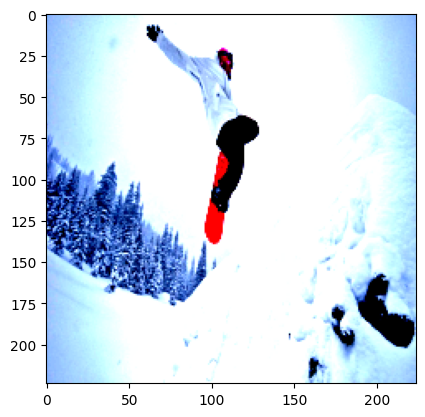

In [14]:
plot_image(img)

In [15]:
target

['THERE IS A MAN THAT IS JUMPING HIGH ON A SNOW BOARD',
 'A snowboarder is in the air as he attempts a stunt.',
 'SNOW BOARDER JUMPING INTO THE AIR ON RED BOARD',
 'A snowboarder jumping high on a snowy day on the mountain.',
 'A man riding an orange snow board jumping off a snow ramp. ']

In [16]:
df = pickle.load(open('./pickle_files/img_id_plus_annotation_df.pickle','rb'))
df.head()

,image_id,captions
0,9,"[Closeup of bins of food that include broccoli and bread., A meal is presented in brightly colored plastic trays., there are containers filled with different kinds of foods, Colorful dishes holding meat, vegetables, fruit, and bread., A bunch of trays that have different food.]"
1,25,"[A giraffe eating food from the top of the tree., A giraffe standing up nearby a tree , A giraffe mother with its baby in the forest., Two giraffes standing in a tree filled area., A giraffe standing next to a forest filled with trees.]"
2,30,"[A flower vase is sitting on a porch stand., White vase with different colored flowers sitting inside of it. , a white vase with many flowers on a stage, A white vase filled with different colored flowers., A vase with red and white flowers outside on a sunny day.]"
3,34,"[A zebra grazing on lush green grass in a field., Zebra reaching its head down to ground where grass is. , The zebra is eating grass in the sun., A lone zebra grazing in some green grass., a Zebra grazing on grass in a green open field.]"
4,36,"[Woman in swim suit holding parasol on sunny day., A woman posing for the camera, holding a pink, open umbrella and wearing a bright, floral, ruched bathing suit, by a life guard stand with lake, green trees, and a blue sky with a few clouds behind., A woman in a floral swimsuit holds a pink umbrella., A woman with an umbrella near the sea, A girl in a bathing suit with a pink umbrella.]"


In [17]:
df.loc[df['image_id'] == 581921, 'captions']

118285    [THERE IS A MAN THAT IS JUMPING HIGH ON A SNOW BOARD, A snowboarder is in the air as he attempts a stunt., SNOW BOARDER JUMPING INTO THE AIR ON RED BOARD, A snowboarder jumping high on a snowy day on the mountain., A man riding an orange snow board jumping off a snow ramp. ]
Name: captions, dtype: object

In [18]:
df.loc[118285]

image_id                                                                                                                                                                                                                                                                                 581921
captions    [THERE IS A MAN THAT IS JUMPING HIGH ON A SNOW BOARD, A snowboarder is in the air as he attempts a stunt., SNOW BOARDER JUMPING INTO THE AIR ON RED BOARD, A snowboarder jumping high on a snowy day on the mountain., A man riding an orange snow board jumping off a snow ramp. ]
Name: 118285, dtype: object

In [19]:
# проверяем доступность 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [20]:
# объявление модели
model = vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
# model = vgg16(pretrained = True)
# заменяем последний полносвязный слой на "пустышку"
model.classifier[5] = torch.nn.Identity()  # Замена последнего слоя на Identity
# заменяем последний полносвязный слой на "пустышку"
model.classifier[6] = torch.nn.Identity()  # Замена последнего слоя на Identity
# переносим модель на GPU
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
# формирование батчей 
# batch -> list(batch_size x (tensor, annotation))


# train_loader = torch.utils.data.DataLoader(train_data,  # исходные данные
#                                            batch_size = 32, # размер батча
#                                            shuffle = False, # не перемешиваем картинки меду собой в батче
#                                            drop_last = True, # удаляем последний пакет данных, если его размер меньше указанного
#                                            collate_fn=lambda x: x
#                                               ) 
# val_loader = torch.utils.data.DataLoader(val_data, 
#                                          batch_size = 32,
#                                          shuffle = False,
#                                          drop_last = True,
#                                          collate_fn=lambda x: x
#                                         )

In [27]:
# замораживаю параметры модели
for parameter in model.parameters():
    parameter.requires_grad = False

In [29]:
# # список векторов
features = []
for image, _ in tqdm(train_data):
    # print(image.shape)
    # перемещение входных данных на GPU
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        # получение выходного вектора
        output = model(image)
        # перемещение выходного вектора на CPU и обновление вектора признаков
        features.append(output.cpu())

# сериализую вектор признаков
pickle.dump(features, open('./pickle_files/VGG16_train_features.pickle','wb'))

In [30]:
# # список векторов
features = []
for image, _ in tqdm(val_data):
    # print(image.shape)
    # перемещение входных данных на GPU
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        # получение выходного вектора
        output = model(image)
        # перемещение выходного вектора на CPU и обновление вектора признаков
        features.append(output.cpu())

# сериализую вектор признаков
pickle.dump(features, open('./pickle_files/VGG16_val_features.pickle','wb'))

100%|██████████| 5000/5000 [00:37<00:00, 131.86it/s]


#### Получаю аннотации из датасета

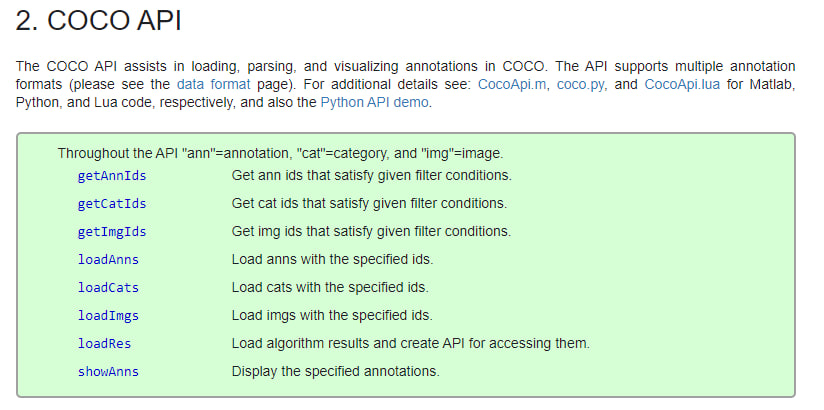

##### Получаю train аннотации

In [70]:
#  COCO API

# cat - category
# ann - annotation
# img - image

coco_train = COCO('../data/annotations/instances_train2017.json')

loading annotations into memory...
Done (t=20.08s)
creating index...
index created!


In [71]:
# display COCO categories and supercategories
cats = coco_train.loadCats(coco_train.getCatIds())   
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms))) # название всех категорий

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
electronic vehicle outdoor animal food person accessory kitchen furniture appliance indoor sports


In [92]:
len(coco_train.getCatIds())  # Всего 80 категорий изображений

80

In [73]:
# get all images containing given categories, select one at random
catIds = coco_train.getCatIds(catNms=['person','dog','skateboard'])  # получаем ID указанных категорий
imgIds = coco_train.getImgIds(catIds=catIds )  # получаем id изображений выбранных категорий
img = coco_train.loadImgs(imgIds)  # загружаем изображения по выбранным категориям
# img
# imgIds = coco.getImgIds(imgIds = [324158])
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [74]:
imgIds = coco_train.getImgIds(imgIds = [324158])
imgIds

[324158]

In [75]:
imgIds = coco_train.getImgIds()
len(imgIds)

118287

In [76]:
imgIds.sort()
imgIds[-1]

581929

In [77]:
img = coco_train.loadImgs(36)[0]
img

{'license': 3,
 'file_name': '000000000036.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000000036.jpg',
 'height': 640,
 'width': 481,
 'date_captured': '2013-11-18 06:56:10',
 'flickr_url': 'http://farm8.staticflickr.com/7216/7200825264_af0f941e1a_z.jpg',
 'id': 36}

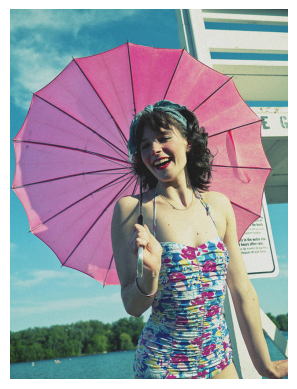

In [78]:
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [79]:
# initialize COCO api for caption annotations
coco_train_caps = COCO('../data/annotations/captions_train2017.json')

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


In [80]:
annIds = coco_train_caps.getAnnIds(imgIds)
anns = coco_train_caps.loadAnns(annIds)
anns[:10]

[{'image_id': 9,
  'id': 661611,
  'caption': 'Closeup of bins of food that include broccoli and bread.'},
 {'image_id': 9,
  'id': 661977,
  'caption': 'A meal is presented in brightly colored plastic trays.'},
 {'image_id': 9,
  'id': 663627,
  'caption': 'there are containers filled with different kinds of foods'},
 {'image_id': 9,
  'id': 666765,
  'caption': 'Colorful dishes holding meat, vegetables, fruit, and bread.'},
 {'image_id': 9,
  'id': 667602,
  'caption': 'A bunch of trays that have different food.'},
 {'image_id': 25,
  'id': 122312,
  'caption': 'A giraffe eating food from the top of the tree.'},
 {'image_id': 25,
  'id': 127076,
  'caption': 'A giraffe standing up nearby a tree '},
 {'image_id': 25,
  'id': 127238,
  'caption': 'A giraffe mother with its baby in the forest.'},
 {'image_id': 25,
  'id': 133058,
  'caption': 'Two giraffes standing in a tree filled area.'},
 {'image_id': 25,
  'id': 133676,
  'caption': 'A giraffe standing next to a forest filled with t

In [81]:
from itertools import groupby

test = anns[:10]
ids = [9,25]
groups = groupby(test, key=lambda x: x['image_id'])
result = [{'image_id': key, 'captions': [item['caption'] for item in group]} for key, group in groups]
result

[{'image_id': 9,
  'captions': ['Closeup of bins of food that include broccoli and bread.',
   'A meal is presented in brightly colored plastic trays.',
   'there are containers filled with different kinds of foods',
   'Colorful dishes holding meat, vegetables, fruit, and bread.',
   'A bunch of trays that have different food.']},
 {'image_id': 25,
  'captions': ['A giraffe eating food from the top of the tree.',
   'A giraffe standing up nearby a tree ',
   'A giraffe mother with its baby in the forest.',
   'Two giraffes standing in a tree filled area.',
   'A giraffe standing next to a forest filled with trees.']}]

In [82]:
# for idd in ids:
#     caption = next(filter(lambda x: x['image_id'] == idd, test))['caption']
#     print(caption)

In [83]:
len(anns)

591753

In [84]:
anns[0]

{'image_id': 9,
 'id': 661611,
 'caption': 'Closeup of bins of food that include broccoli and bread.'}

In [85]:
from itertools import groupby

groups = groupby(anns, key=lambda x: x['image_id'])
result = [{'image_id': key, 'captions': [item['caption'] for item in group]} for key, group in groups]
# result

In [86]:
result[:5]

[{'image_id': 9,
  'captions': ['Closeup of bins of food that include broccoli and bread.',
   'A meal is presented in brightly colored plastic trays.',
   'there are containers filled with different kinds of foods',
   'Colorful dishes holding meat, vegetables, fruit, and bread.',
   'A bunch of trays that have different food.']},
 {'image_id': 25,
  'captions': ['A giraffe eating food from the top of the tree.',
   'A giraffe standing up nearby a tree ',
   'A giraffe mother with its baby in the forest.',
   'Two giraffes standing in a tree filled area.',
   'A giraffe standing next to a forest filled with trees.']},
 {'image_id': 30,
  'captions': ['A flower vase is sitting on a porch stand.',
   'White vase with different colored flowers sitting inside of it. ',
   'a white vase with many flowers on a stage',
   'A white vase filled with different colored flowers.',
   'A vase with red and white flowers outside on a sunny day.']},
 {'image_id': 34,
  'captions': ['A zebra grazing o

In [87]:
import pandas as pd
df = pd.DataFrame.from_dict(result, orient = 'columns')
df.head()

,image_id,captions
0,9,"[Closeup of bins of food that include broccoli and bread., A meal is presented in brightly colored plastic trays., there are containers filled with different kinds of foods, Colorful dishes holding meat, vegetables, fruit, and bread., A bunch of trays that have different food.]"
1,25,"[A giraffe eating food from the top of the tree., A giraffe standing up nearby a tree , A giraffe mother with its baby in the forest., Two giraffes standing in a tree filled area., A giraffe standing next to a forest filled with trees.]"
2,30,"[A flower vase is sitting on a porch stand., White vase with different colored flowers sitting inside of it. , a white vase with many flowers on a stage, A white vase filled with different colored flowers., A vase with red and white flowers outside on a sunny day.]"
3,34,"[A zebra grazing on lush green grass in a field., Zebra reaching its head down to ground where grass is. , The zebra is eating grass in the sun., A lone zebra grazing in some green grass., a Zebra grazing on grass in a green open field.]"
4,36,"[Woman in swim suit holding parasol on sunny day., A woman posing for the camera, holding a pink, open umbrella and wearing a bright, floral, ruched bathing suit, by a life guard stand with lake, green trees, and a blue sky with a few clouds behind., A woman in a floral swimsuit holds a pink umbrella., A woman with an umbrella near the sea, A girl in a bathing suit with a pink umbrella.]"


In [88]:
df.shape

(118287, 2)

In [68]:
# сериализую вектор аннотаций
pickle.dump(df, open('./pickle_files/train_img_id_plus_annotation_df.pickle','wb'))

##### Получаю val аннотации

In [120]:
coco_val = COCO('../data/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


In [121]:
# display COCO categories and supercategories
# cats = coco_val.loadCats(coco_val.getCatIds())   
# nms=[cat['name'] for cat in cats]
# print('COCO categories: \n{}\n'.format(' '.join(nms))) # название всех категорий

# nms = set([cat['supercategory'] for cat in cats])
# print('COCO supercategories: \n{}'.format(' '.join(nms)))

In [122]:
len(coco_val.getCatIds())  # Всего 80 категорий изображений

80

In [123]:
# catIds = coco_val.getCatIds(catNms=['person','dog','skateboard'])  # получаем ID указанных категорий
# imgIds = coco_val.getImgIds(catIds=catIds )  # получаем id изображений выбранных категорий
# img = coco_val.loadImgs(imgIds)  # загружаем изображения по выбранным категориям

In [124]:
# imgIds = coco_val.getImgIds(imgIds = [324158])
# imgIds

In [125]:
val_imgIds = coco_val.getImgIds()
len(val_imgIds)

5000

In [128]:
val_imgIds.sort()
val_imgIds[:10]

[139, 285, 632, 724, 776, 785, 802, 872, 885, 1000]

In [129]:
img = coco_val.loadImgs(285)[0]
img

{'license': 4,
 'file_name': '000000000285.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000000285.jpg',
 'height': 640,
 'width': 586,
 'date_captured': '2013-11-18 13:09:47',
 'flickr_url': 'http://farm8.staticflickr.com/7434/9138147604_c6225224b8_z.jpg',
 'id': 285}

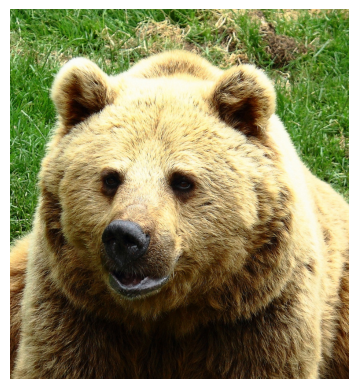

In [130]:
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [131]:
# initialize COCO api for caption annotations
coco_val_caps = COCO('../data/annotations/captions_val2017.json')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [135]:
val_annIds = coco_val_caps.getAnnIds(val_imgIds)
val_anns = coco_val_caps.loadAnns(annIds)
val_anns[:10]

[{'image_id': 139,
  'id': 372891,
  'caption': 'A woman stands in the dining area at the table.'},
 {'image_id': 139,
  'id': 376968,
  'caption': 'A room with chairs, a table, and a woman in it.'},
 {'image_id': 139,
  'id': 379917,
  'caption': 'A woman standing in a kitchen by a window'},
 {'image_id': 139,
  'id': 382074,
  'caption': 'A person standing at a table in a room.'},
 {'image_id': 139,
  'id': 384831,
  'caption': 'A living area with a television and a table'},
 {'image_id': 285,
  'id': 652864,
  'caption': 'A big burly grizzly bear is show with grass in the background.'},
 {'image_id': 285,
  'id': 658909,
  'caption': 'The large brown bear has a black nose.'},
 {'image_id': 285,
  'id': 662422,
  'caption': 'Closeup of a brown bear sitting in a grassy area.'},
 {'image_id': 285,
  'id': 666775,
  'caption': 'A large bear that is sitting on grass. '},
 {'image_id': 285,
  'id': 668473,
  'caption': "A close up picture of a brown bear's face."}]

In [136]:
len(val_anns)

25014

In [137]:
from itertools import groupby

groups = groupby(val_anns, key=lambda x: x['image_id'])
val_result = [{'image_id': key, 'captions': [item['caption'] for item in group]} for key, group in groups]

In [139]:
val_result[:5]

[{'image_id': 139,
  'captions': ['A woman stands in the dining area at the table.',
   'A room with chairs, a table, and a woman in it.',
   'A woman standing in a kitchen by a window',
   'A person standing at a table in a room.',
   'A living area with a television and a table']},
 {'image_id': 285,
  'captions': ['A big burly grizzly bear is show with grass in the background.',
   'The large brown bear has a black nose.',
   'Closeup of a brown bear sitting in a grassy area.',
   'A large bear that is sitting on grass. ',
   "A close up picture of a brown bear's face."]},
 {'image_id': 632,
  'captions': ['Bedroom scene with a bookcase, blue comforter and window.',
   'A bedroom with a bookshelf full of books.',
   'This room has a bed with blue sheets and a large bookcase',
   'A bed and a mirror in a small room.',
   'a bed room with a neatly made bed a window and a book shelf']},
 {'image_id': 724,
  'captions': ["A stop sign is mounted upside-down on it's post. ",
   'A stop si

In [140]:
val_df = pd.DataFrame.from_dict(val_result, orient = 'columns')
val_df.head()

,image_id,captions
0,139,"[A woman stands in the dining area at the table., A room with chairs, a table, and a woman in it., A woman standing in a kitchen by a window, A person standing at a table in a room., A living area with a television and a table]"
1,285,"[A big burly grizzly bear is show with grass in the background., The large brown bear has a black nose., Closeup of a brown bear sitting in a grassy area., A large bear that is sitting on grass. , A close up picture of a brown bear's face.]"
2,632,"[Bedroom scene with a bookcase, blue comforter and window., A bedroom with a bookshelf full of books., This room has a bed with blue sheets and a large bookcase, A bed and a mirror in a small room., a bed room with a neatly made bed a window and a book shelf]"
3,724,"[A stop sign is mounted upside-down on it's post. , A stop sign that is hanging upside down., An upside down stop sign by the road., a stop sign put upside down on a metal pole , A stop sign installed upside down on a street corner]"
4,776,"[Three teddy bears, each a different color, snuggling together., Three stuffed animals are sitting on a bed. , three teddy bears giving each other a hug, A group of three stuffed animal teddy bears., Three stuffed bears hugging and sitting on a blue pillow]"


In [141]:
val_df.shape

(5000, 2)

In [142]:
# сериализую вектор аннотаций
pickle.dump(val_df, open('./pickle_files/val_img_id_plus_annotation_df.pickle','wb'))

#### Предобработка текста аннотаций

In [14]:
train_df = pickle.load(open('./pickle_files/train_img_id_plus_annotation_df.pickle','rb'))
train_df.head()

,image_id,captions
0,9,"[Closeup of bins of food that include broccoli and bread., A meal is presented in brightly colored plastic trays., there are containers filled with different kinds of foods, Colorful dishes holding meat, vegetables, fruit, and bread., A bunch of trays that have different food.]"
1,25,"[A giraffe eating food from the top of the tree., A giraffe standing up nearby a tree , A giraffe mother with its baby in the forest., Two giraffes standing in a tree filled area., A giraffe standing next to a forest filled with trees.]"
2,30,"[A flower vase is sitting on a porch stand., White vase with different colored flowers sitting inside of it. , a white vase with many flowers on a stage, A white vase filled with different colored flowers., A vase with red and white flowers outside on a sunny day.]"
3,34,"[A zebra grazing on lush green grass in a field., Zebra reaching its head down to ground where grass is. , The zebra is eating grass in the sun., A lone zebra grazing in some green grass., a Zebra grazing on grass in a green open field.]"
4,36,"[Woman in swim suit holding parasol on sunny day., A woman posing for the camera, holding a pink, open umbrella and wearing a bright, floral, ruched bathing suit, by a life guard stand with lake, green trees, and a blue sky with a few clouds behind., A woman in a floral swimsuit holds a pink umbrella., A woman with an umbrella near the sea, A girl in a bathing suit with a pink umbrella.]"


In [15]:
val_df = pickle.load(open('./pickle_files/val_img_id_plus_annotation_df.pickle','rb'))
val_df.head()

,image_id,captions
0,139,"[A woman stands in the dining area at the table., A room with chairs, a table, and a woman in it., A woman standing in a kitchen by a window, A person standing at a table in a room., A living area with a television and a table]"
1,285,"[A big burly grizzly bear is show with grass in the background., The large brown bear has a black nose., Closeup of a brown bear sitting in a grassy area., A large bear that is sitting on grass. , A close up picture of a brown bear's face.]"
2,632,"[Bedroom scene with a bookcase, blue comforter and window., A bedroom with a bookshelf full of books., This room has a bed with blue sheets and a large bookcase, A bed and a mirror in a small room., a bed room with a neatly made bed a window and a book shelf]"
3,724,"[A stop sign is mounted upside-down on it's post. , A stop sign that is hanging upside down., An upside down stop sign by the road., a stop sign put upside down on a metal pole , A stop sign installed upside down on a street corner]"
4,776,"[Three teddy bears, each a different color, snuggling together., Three stuffed animals are sitting on a bed. , three teddy bears giving each other a hug, A group of three stuffed animal teddy bears., Three stuffed bears hugging and sitting on a blue pillow]"


Чтобы работать с текстовыми данными необходимо конвертировать их в числа. 

Для этого нам необходим токенайзер, который создаст словарь и каждому слову в словаре пставит в соответсиве число.

Будем тренировать с нуля свой токенайзер. Для этого нам неодходимо создать файл .txt, в котором будут записаны через запятую все наши примеры с описаниями.

In [16]:
# [[str, str, str, str, str], [str, str, str, str, str], ...]
train_captions = list(train_df['captions'])
train_captions[:3]

[['Closeup of bins of food that include broccoli and bread.',
  'A meal is presented in brightly colored plastic trays.',
  'there are containers filled with different kinds of foods',
  'Colorful dishes holding meat, vegetables, fruit, and bread.',
  'A bunch of trays that have different food.'],
 ['A giraffe eating food from the top of the tree.',
  'A giraffe standing up nearby a tree ',
  'A giraffe mother with its baby in the forest.',
  'Two giraffes standing in a tree filled area.',
  'A giraffe standing next to a forest filled with trees.'],
 ['A flower vase is sitting on a porch stand.',
  'White vase with different colored flowers sitting inside of it. ',
  'a white vase with many flowers on a stage',
  'A white vase filled with different colored flowers.',
  'A vase with red and white flowers outside on a sunny day.']]

In [17]:
len(train_captions)

118287

In [18]:
val_captions = list(val_df['captions'])
val_captions[:3]

[['A woman stands in the dining area at the table.',
  'A room with chairs, a table, and a woman in it.',
  'A woman standing in a kitchen by a window',
  'A person standing at a table in a room.',
  'A living area with a television and a table'],
 ['A big burly grizzly bear is show with grass in the background.',
  'The large brown bear has a black nose.',
  'Closeup of a brown bear sitting in a grassy area.',
  'A large bear that is sitting on grass. ',
  "A close up picture of a brown bear's face."],
 ['Bedroom scene with a bookcase, blue comforter and window.',
  'A bedroom with a bookshelf full of books.',
  'This room has a bed with blue sheets and a large bookcase',
  'A bed and a mirror in a small room.',
  'a bed room with a neatly made bed a window and a book shelf']]

In [19]:
len(val_captions)

5000

In [20]:
# из [[str, str, str, str, str], [str, str, str, str, str], ...] в [str, str, str, str, str, ...]
all_train_captions_list = [sample for caption in train_captions for sample in caption]
all_train_captions_list[:8]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.',
 'A giraffe eating food from the top of the tree.',
 'A giraffe standing up nearby a tree ',
 'A giraffe mother with its baby in the forest.']

In [124]:
# запишем список в файл .txt, который потом подадим на вход токенайзеру
with open('train_captions.txt', 'w') as file:
    for caption in all_train_captions_list:
        file.write(caption)

In [125]:
# инициализируем токенайзер
bwpt = BertWordPieceTokenizer(vocab = None,         # использовать готовый словарь. None: сгенерировать свой словарь
                              unk_token = '[UNK]',  # токен неизвестного слова
                              sep_token = '[SEP]',  # токен конца предложения
                              cls_token = '[CLS]',  # токен начала предложения
                              clean_text = True,    # очистить текст от знаков препинания и других ненужных символов
                              handle_chinese_chars = True, # обрабатывать китайские иероглифы
                              strip_accents = True,   # удалить знаки препинания
                              lowercase = True,       # привести к нижнему регистру
                              wordpieces_prefix = '##') # префикс для частей слова.
                                                        # например, слово sleeping будет разбито на sleep и ##ing

In [126]:
# обучаем токенайзер на тексте аннотаций
bwpt.train(files = ['train_captions.txt'],     # файл с текстом аннотаций
           vocab_size = 30000,           # размер словаря
           min_frequency = 50,            # зададим с какой частотой оставим слова. если слово встречалось минимум 5 раз, то включаем его в словарь
           limit_alphabet = 1000,        # максимальное количество символов, которое нужно сохранить в алфавите
           special_tokens = ['[PAD]','[UNK]', '[CLS]', '[MASK]', '[SEP]'], # добавим специальные токены
           show_progress = True)   
# bwpt.save("./tokenizer.json")
bwpt.save_model('./bert-it', 'bert-it')

['./bert-it/bert-it-vocab.txt']

In [378]:
# 10 целевых токенов + токен начала и конца предложения
length = 12

# инициализируем токенайзер используя сгенерированный словарь
tokenizer = BertWordPieceTokenizer('./bert-it/bert-it-vocab.txt')
tokenizer.enable_truncation(max_length = length)
tokenizer.enable_padding(length = length)

In [379]:
enc = tokenizer.encode('A woman posing for the camera, holding a pink, open umbrella and wearing a bright, floral, ruched bathing suit, by a life guard stand with lake, green trees, and a blue sky with a few clouds behind.')
enc

Encoding(num_tokens=12, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [380]:
enc.ids

[2, 41, 195, 915, 346, 114, 858, 16, 220, 41, 848, 4]

In [381]:
dec = tokenizer.decode(enc.ids)
dec

'a woman posing for the camera, holding a pink'

In [382]:
vocab = tokenizer.get_vocab()

In [383]:
vocab_size = tokenizer.get_vocab_size()
vocab_size

6471

Создадим датасет.

In [384]:
class CustomDataset(Dataset):
    def __init__(self, images, captions, tokenizer):
        self.images = images
        self.captions = captions
        self.tokenizer = tokenizer
    
    # возвращаю количество примеров в датасете
    def __len__(self):
        return len(self.images)
    
    # по индексу возвращаем словарь, содержащий описание и изображение
    def __getitem__(self, index):
        
        # image = self.images[index].tolist()
        
        # тензор изображения - РАЗМЕРНОСТЬ [1, cnn_feature_dim]
        # по индексу берем вектор изображения
        image = self.images[index]
        
        # по индексу возьмем первое описание для изображения
        caption = self.captions[index][0]
        
        # токенезируем описание, будем брать первое описание из 5 доступных
        # ['A bunch of trays that have different food.'] => [2, 41, 602, 112, 2462, 218, 1229, 681, 347, 18, 4]
        
        # 2 - [CLS] - начало предложения
        # 4 - [SEP] - конец предложения
        
        # РАЗМЕРНОСТЬ [seq_len]
        caption = torch.tensor(self.tokenizer.encode(caption).ids)
        return {'image_vector':image, 'caption':caption}

In [385]:
train_images = pickle.load(open('./pickle_files/VGG16_train_features.pickle','rb'))
type(train_images)

list

In [386]:
len(train_images), train_images[0].shape

(118287, torch.Size([1, 4096]))

In [387]:
val_images = pickle.load(open('./pickle_files/VGG16_val_features.pickle','rb'))

In [388]:
len(val_images), val_images[0].shape

(5000, torch.Size([1, 4096]))

In [389]:
data = CustomDataset(images = train_images,
                      captions = train_captions,
                      tokenizer = tokenizer)

In [390]:
len(data)

118287

In [391]:
data[0]['image_vector'].shape

torch.Size([1, 4096])

In [392]:
data[0]['caption']

tensor([   2, 2060,  112, 5575,  112,  347,  218, 4029,  818,  122, 1166,    4])

In [393]:
data[16]['caption'].tolist().count(tokenizer.token_to_id('[CLS]'))

1

In [394]:
tokenizer.token_to_id('[CLS]')

2

In [395]:
def filter_dataset(dataset, tokenizer = tokenizer, token = '[UNK]'):
    token_id_to_filter = tokenizer.token_to_id(token)
    
    filtered_images = []
    filtered_captions = []
    
    for item in dataset:
        caption = item['caption'].tolist()

        token_count_in_caption = caption.count(token_id_to_filter)

        if token_count_in_caption <= 2:
            filtered_images.append(item['image_vector'])
            
            filtered_captions.append([tokenizer.decode(caption)])

    filtered_data = CustomDataset(images=filtered_images, captions=filtered_captions, tokenizer=tokenizer)
    return filtered_data

In [396]:
filtered_data = filter_dataset(data)

In [397]:
filtered_data[0]['caption']

tensor([   2, 2060,  112, 5575,  112,  347,  218, 4029,  818,  122, 1166,    4])

In [398]:
data[0]['caption']

tensor([   2, 2060,  112, 5575,  112,  347,  218, 4029,  818,  122, 1166,    4])

In [399]:
len(filtered_data)

118287

Все предложения имею разную длину, нам нужно в нейросеть подавать батчи одинаковой размерности, для этого нам нужно знать максимальную длину предложения, чтобы все вектора добить до максимальной длины нулями.

т.к. используется RNN, по своему постороению медленная, и если мы будем каждый раз обрабатывать вектор максимальной длины, то обучение будет слишком долгим.

Чтобы решить эту проблему, мы построим распределение длины описаний и возьмем минимально возможную длину, которая охватывает максимальное количество примеров. Описания большей длины будут обрезаны.

In [400]:
max_len = max(len(caption.split()) for caption in all_train_captions_list)
max_len

49

In [401]:
# посчитаем количество слов в каждом описании
distribution = [len(caption.split()) for caption in all_train_captions_list]

Text(0.5, 0, 'Data')

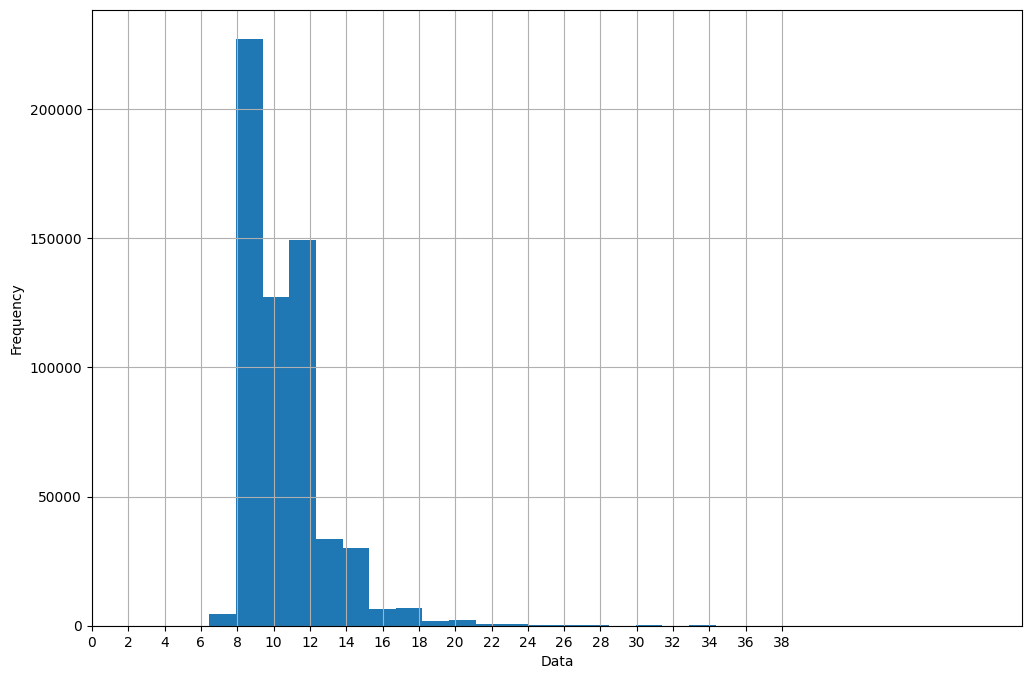

In [402]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
plt.hist(distribution, bins = 30)
plt.xticks(range(0, 40, 2))
plt.grid()
plt.ylabel('Frequency')
plt.xlabel('Data')

Из гистограммы видно, что если мы возьмем максимальную длину предложения равной 15, то охватим достаточно много примеров.

Создадим функцию, в которой настроим, как нам необходимо разбить датасет на батчи. В нашем случае, мы возьмем максимальную длину 15. Не забудем про спец. токены начала и конца предложения.
Итого максимальная длина будет 15 + 2 = 17.

Обратим внимание, что вектор image_dim - это вектор с извлеченными фичами из CNN модели. Вектор, который обычно напрвляется в полносвязный слой для классификации.

Чтобы сгенерировать батчи, мы создадим матрицы с нулевыми значениями, т.к. ноль у нас по умолчанию является индексом паддинга. Паддинг - это значение, которым
"добиваем" вектор до нужной длины.

Пример добавления паддинга:

[10, 43, 54, 132, 2] => [10, 43, 54, 132, 2, 0, 0, 0, ..., 0]

In [403]:
# def collate_fn(dataset, max_len = 15, image_dim = 4096):
#     # укажем максимальную длину с учётом спец токенов
#     max_len += 2 # begin and end of sentence tokens
    
#     # новая длина датасета после того, как из него уберем все векторы больше 17
#     filtered_vectors = 0
#     # инициализируем две матрицы, состоящие из нулей, в которые будем добавлять вектора описаний и изображений
    
#     # new_inputs - нулевая матрица для векторов изображений, размерность [кол-во примеров x размерность вектора изображения на выходе из CNN]
#     new_inputs = torch.zeros((len(dataset), image_dim), dtype = torch.float)
    
#     # new_outputs - нулевая матрица для описаний, размерность [кол-во примеров x макс. длина вектора, которую определили ранее]
#     new_outputs = torch.zeros(len(dataset), max_len, dtype = torch.long)
#     # пробежимся по всему датасету
#     # sample: {'inputs': image, 'outputs':caption} как определили в классе ExtDataset
#     for i, sample in tqdm(enumerate(dataset)):
        
#         # new_outputs[i, :len(sample['outputs'])] += np.array(sample['outputs'])
#         try:
#             # берем i-ю строку и добавляем в нее вектор описания [0, 0, 0, 0 ..., 0] =>[100, 32, 2  ..., 876, 213, 98]
#             new_outputs[i, :len(sample['outputs'])] += np.array(sample['outputs'])
        
#         except ValueError:    # Ошибка ValueError появляется, когда длина вектора описания > max_len 
#             filtered_vectors += 1
#             continue          # Ранее договорились, что если вектор описания больше > 17, то его не учитываем в конечном датасете
        
#         # берем i-ю строку и добавляем в нее вектор изображения [0, 0, 0, 0, ..., 0] =>[0.0000, 1.1075, 0.359  ..., 0.0000, 0.0000, 0.0000]
#         new_inputs[i, :] += np.array(sample['inputs'])
    
#     # new_len = len(dataset) - filtered_vectors
#     # new_inputs = new_inputs[:new_len, :]
#     # new_outputs = new_outputs[:new_len, :]
    
    
#     ## ИСПРАВИТЬ
    
    
#     # возвращаем заполненные матрицы
#     return {'input_ids':new_inputs, 'outputs':new_outputs, 'new_len':new_len}

In [404]:
# clean_data = collate_fn(data)

In [405]:
# clean_data['new_len']

In [406]:
# len(clean_data['input_ids'])

Создадим энкодер, который будет брать вектор изображения и кодировать его в размерность скрытого слоя нашей RNN модели. Далее выход энкодера будем  подавать на вход RNN системе в качестве скрытого состояния.

In [407]:
class ImageEncoder(torch.nn.Module):
    # hid_dim - размерность вектора скрытого состояния
    # n_layers - кол-во слоёв в RNN архитектуре, по умолчанию будет использовать LSTM с 2-мя слоями
    # для этого нужно подготовить правильную размерность для скрытых состояний [n_layers, batch_size, hid_dim]
    # cnn_features_dim - размерность извлеченного CNN моделью вектора с фичами из изображения
    
    def __init__(self,
                 hid_dim = 512,
                 n_layers = 1,
                 cnn_features_dim = 4096):
        
        super(ImageEncoder, self).__init__()
        
        self.n_layers = n_layers
        
        # инициализируем линейные слои
        self.cnn_to_h0 = nn.Linear(cnn_features_dim, hid_dim)
        self.cnn_to_c0 = nn.Linear(cnn_features_dim, hid_dim)
        
        
    def forward(self, image_vectors):
        # ВХОД 
        # image_vectors - РАЗМЕРНОСТЬ [batch_size, cnn_features_dim], тензор, содержащий тензоры признаков для изображений в батче
        
        # меняем dtype из float64 в float32        
        image_vectors = image_vectors.float()
        
        # ВЫХОДЫ
        # initial_h - РАЗМЕРНОСТЬ [n layers, batch size, hid dim], тензор, содержащий начальное скрытое состояние
        # initial_c - РАЗМЕРНОСТЬ [n layers, batch size, hid dim], тензор, содержащий начальное состояние ячейки
        
        initial_h = self.cnn_to_h0(image_vectors).repeat(self.n_layers, 1, 1)
        initial_c = self.cnn_to_c0(image_vectors).repeat(self.n_layers, 1, 1)
        
        return initial_h, initial_c

In [408]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [409]:
image_vectors = torch.rand(10, 4096).to(device)   # [batch_size, cnn_features_dim]
encoder = ImageEncoder().to(device)
initial_h, initial_c = encoder.forward(image_vectors)
initial_h.shape, initial_c.shape

(torch.Size([1, 10, 512]), torch.Size([1, 10, 512]))

In [410]:
print(next(encoder.parameters()).device)

cuda:0


Создадим модель, которая на вход принимает вектор с фичами, извлеченными из изображения с помощью CNN, а на выходе будет выдавать логиты, распределение на слова в словаре.

In [411]:
class LSTM_Caption(torch.nn.Module):
    # emb_dim : размерность вектора слова
    # hid_dim : размерность скрытого состояния RNN
    # n_layers : количество слоев в RNN
    # cnn_feature_dim : размерность вектора с фичами, извлеченного CNN моделью
    # vocab_size : размер словаря
    
    def __init__(self,
                 emb_dim = 256, 
                 hid_dim = 512, 
                 n_layers = 1, 
                 cnn_feature_dim = 4096, 
                 # dropout = 0.3, 
                 vocab_size = vocab_size):
        
         # вызываем конструктор родительского класса nn.Module и инициализируем базовый функционал модуля
        super(LSTM_Caption, self).__init__() 
        
        # размер словаря
        self.vocab_size = vocab_size
        
        # создадим матрицу хранящую эмбеддинги (вектора) слов
        # аргумент 1 - размер словаря, аргумент 2 - размер вектора эмбеддинга
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        
        # инициализируем lstm модель
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers)
        
        # инициализируем линейный слой для получения логитов
        self.fc = nn.Linear(hid_dim, vocab_size)
        self.softmax = nn.LogSoftmax(dim = 1)    
    
    # функция прямого прохода для 1 слова
    def forward(self, token_indexes, h, c):
        
        # token_indexes - РАЗМЕРНОСТЬ [batch_size], тензор, содержащий индексы токенов из последовательностей в батче
        
        # выбираем нужный эмбеддинг слова по его индексу из вектора эмбеддингов
        tokens_embed = self.embedding(token_indexes).unsqueeze(dim=0)
           
        # ВХОДЫ
        # tokens_embed - РАЗМЕРНОСТЬ [1, batch_size, emb_dim], тензор, содержащий эмбеддингши входных токенов 
        # h - РАЗМЕРНОСТЬ [n layers, batch size, hid dim], тензор, содержащий скрытое состояние для каждого токена во входной последовательности 
        # c - РАЗМЕРНОСТЬ [n layers, batch size, hid dim], тензор, содержащий состояние ячейки для каждого токена во входной последовательности

        # ВЫХОДЫ
        # output - РАЗМЕРНОСТЬ [batch_size, vocab_size], тензор, содержащий распределение вероятностей токенов на шаге t+1. 
        # токен с наибольшей вероятностью в этом векторе, будет следующим в последовательности
        
        # hn - РАЗМЕРНОСТЬ [n layers, batch size, hid dim], тензор, содержащий конечное скрытое состояние для каждого токена в последовательности
        # cn - РАЗМЕРНОСТЬ [n layers, batch size, hid dim], тензор, содержащий конечное состояние ячейки для каждого токена в последовательности
        
        output, (hn, cn) = self.lstm(tokens_embed, (h,c))
        output = self.fc(output)
        output = self.softmax(output.squeeze(0))
        
        # output - РАЗМЕРНОСТЬ [batch_size, vocab_size]
        # hn - РАЗМЕРНОСТЬ [n layers, batch size, hid dim]
        # cn - РАЗМЕРНОСТЬ [n layers, batch size, hid dim]
        return output, hn, cn
    
    def sample(self,
               initial_h,         # тензор, содержащий начальное скрытое состояние
               initial_c,         # тензор, содержащий начальное состояние ячейки
               target_sequences): # целевые последовательности, РАЗМЕРНОСТЬ [batch_size, seq_len]
        
        batch_size = target_sequences.shape[0]
        
        seq_len = target_sequences.shape[1]  # длина последовательности (=17)
        
        # start_token_indexes - РАЗМЕРНОСТЬ [batch_size], тензор, содержащий n = batch_size индексов стартового токена
        # start_token_indexes = tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
        start_token_indexes = target_sequences[:,0] 

        # Инициализируем тензор, в котором будут храниться последовательности для каждого батча
        # predicted_sequences - РАЗМЕРНОСТЬ [seq_len, batch_size, vocab_size]
        predicted_sequences = torch.zeros(seq_len, batch_size, self.vocab_size)
        
        h = initial_h
        c = initial_c
        
        for t in range(1, seq_len):
            
            # тензор с вероятностями следующего слова, скрытым состоянием и памятью ячеек
            # output - РАЗМЕРНОСТЬ [batch_size, vocab_size]
            output, h, c = self.forward(start_token_indexes, h, c)
            
            predicted_sequences[t] = torch.exp(output)
            
            # меняем стартовые токены в батчах на токены из таргет последовательностей
            start_token_indexes = target_sequences[:,t]
        
        # predicted_sequences - РАЗМЕРНОСТЬ [seq_len, batch_size, vocab_size]
        return predicted_sequences

In [416]:
batch_size = 10
seq_len = 12
token_indexes = torch.randint(3, 15,size = (batch_size,)).to(device)   # для проверки функции forward
token_indexes

tensor([10,  3,  7, 10,  5,  4, 12,  4,  4,  4], device='cuda:0')

In [417]:
decoder = LSTM_Caption().to(device)
output, initial_h, initial_c = decoder.forward(token_indexes, initial_h, initial_c)
output.shape, initial_h.shape, initial_c.shape

(torch.Size([10, 6471]), torch.Size([1, 10, 512]), torch.Size([1, 10, 512]))

In [418]:
output[0]

tensor([-8.8018, -8.8704, -8.7610,  ..., -8.7447, -8.6815, -8.8166],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [419]:
target_sequences = torch.randint(3,15, size = (batch_size, seq_len)).to(device)
target_sequences.shape[1]

12

In [420]:
target_sequences

tensor([[ 6, 10,  9,  9, 11, 13, 10, 10, 10,  7,  6,  6],
        [ 4,  4, 12, 11, 11, 14, 14,  4, 13,  9,  3, 12],
        [ 8,  9,  3,  8,  8,  6,  9,  7, 10,  7, 10,  6],
        [ 7,  6,  7, 14,  3,  4,  9,  4, 12, 12, 13, 11],
        [ 7,  4, 12,  9, 12,  4,  6, 14, 10,  5, 12,  4],
        [10,  9,  7,  8,  9, 14,  9, 13, 11,  5,  8, 14],
        [ 8,  6, 14,  8,  4, 13,  8,  9,  3,  9,  4,  8],
        [ 5,  3,  4, 13, 12, 14, 14, 10, 11,  4, 10, 10],
        [ 9,  5, 14, 14,  9,  7,  6,  5, 10,  7, 14, 10],
        [13,  3,  3, 10, 10, 10,  6,  4,  7, 13,  4,  4]], device='cuda:0')

In [421]:
decoder.sample(initial_h, initial_c, target_sequences).shape

torch.Size([12, 10, 6471])

In [422]:
decoder.sample(initial_h, initial_c, target_sequences)[9][9].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

Соберем конечную модель из энкодера и декодера. Будем обучать методом teacher forcing. В каждый момент времени t, когда модель сгенерировала токен, будем на следующий шаг обучения t+1 отдавать модели сгенерированный ею токен или правильный (как в описании).

In [423]:
class ImageCaption(torch.nn.Module):
    def __init__(self,
                 encoder, 
                 decoder,
                 seq_len):
        
        super(ImageCaption, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.seq_len = seq_len
        
    def forward(self, 
                image_vectors,
                target_sequences 
                # teacher_forcing_ratio = 0.5
               ):
        
        # image_vectors - РАЗМЕРНОСТЬ [batch_size, cnn_features_dim], тензор, содержащий n = batch_size векторов признаков изображения
        # target_sequences - РАЗМЕРНОСТЬ [batch_size, seq_len], тензор, содержащий n = batch_size векторов индексов целевых описаний изображений
    
        # initial_h - РАЗМЕРНОСТЬ [n layers, batch size, hid dim], тензор, содержащий начальное скрытое состояние
        # initial_c - РАЗМЕРНОСТЬ [n layers, batch size, hid dim], тензор, содержащий начальное состояние ячейки
        initial_h, initial_c = self.encoder.forward(image_vectors)
        
        
        predicted_sequences = self.decoder.sample(initial_h, initial_c, target_sequences)
        # predicted_sequences - РАЗМЕРНОСТЬ [seq_len, batch_size, vocab_size]
        return predicted_sequences
    
    def generate_one_caption(self, transformed_image, cnn_net):
        # transformed_image - РАЗМЕРНОСТЬ [channel,width, height]
        # cnn_net: подготовденная модель CNN для извлечения фич из изображения
                
        transformed_image = transformed_image.unsqueeze(0)
        
        # извлечем фичи из изображения
        # image_vector - РАЗМЕРНОСТЬ [1, 4096]
        image_vector = cnn_net(transformed_image)
        
        initial_h, initial_c = self.encoder.forward(image_vector)
        
        h = initial_h
        c = initial_c
        
        predicted_sequence = []
        
        # в токенайзере возьмем id токена означающего начало опписания
        start_token_index = torch.tensor([tokenizer.token_to_id('[CLS]')]).to(device)
        
        for t in range(1, self.seq_len):
            
            # тензор с вероятностями следующего слова, скрытым состоянием и памятью ячеек
            # output - РАЗМЕРНОСТЬ [batch_size, vocab_size], тензор, содержащий распределение вероятностей токенов на шаге t+1. 
            # токен с наибольшей вероятностью в этом векторе, будет следующим в последовательности
            output, h, c = self.decoder.forward(start_token_index, h, c)
            
            output = torch.multinomial(torch.exp(output), 1)
            
            # записываем индексы 
            # predicted_sequence - [torch.tensor([24]), torch.tensor([645]), ...]
            # predicted_sequence - РАЗМЕРНОСТЬ [seq_len]
            predicted_sequence.append(output.view(-1).data)
            
            # меняем стартовые токены в батчах на только что сгенерированные
            start_token_index = output.view(-1).data
            
        # у токенайзера возьмем id токена, означающего конец описания
        EOS_IDX = tokenizer.token_to_id('[SEP]')
        
        # возьмем последовательность токенов и сгенерируем описание  [100, 23423, 321, 242, ..., 101]
        for t in predicted_sequence:
            if t.item() != EOS_IDX:
                print(tokenizer.id_to_token(t.item()), end = ' ')
            else:
                break

In [425]:
# объявление модели
cnn_net = vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
# model = vgg16(pretrained = True)
# заменяем последний полносвязный слой на "пустышку"
cnn_net.classifier[5] = torch.nn.Identity()  # Замена последнего слоя на Identity
# заменяем последний полносвязный слой на "пустышку"
cnn_net.classifier[6] = torch.nn.Identity()  # Замена последнего слоя на Identity

# замораживаю параметры модели
for parameter in cnn_net.parameters():
    parameter.requires_grad = False

# переносим модель на GPU
cnn_net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [426]:
# функция для генерации одного описания
def get_image_caption(path):
    
    # скачиваем изображение по ссылке и сохраняем как img.png
    # !wget -O image.jpg url
    # time.sleep(1.5)
    
    # # прочитаем изображение
    image = Image.open(path)
    
    # инициализируем этапы предобработки датасета изображений
    transform = transforms.Compose([
                                    #приводим к нужному размеру
                                    transforms.Resize((224,224)),
                                    # превращаем изображение в тензор
                                    transforms.ToTensor(),                                
                                    # transforms.PILToTensor(),
                                    # Зачем нужна нормализация???
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],     
                                                         std=[0.229, 0.224, 0.225])])
    # Применяем transform к изображению
    transformed_image = transform(image)
    
    # отобразим изображение
    plot_image(transformed_image)
    
    # переносим данные на GPU
    transformed_image = transformed_image.to(device)

    # сгенерируем описание используя метод generate_caption  ImageCaption
    model.generate_one_caption(transformed_image, cnn_net)

In [427]:
batch_size = 10
seq_len = 12
cnn_features_dim = 4096


image_vectors = torch.rand(batch_size, cnn_features_dim).to(device)             # [batch_size, cnn_features_dim]
target_sequences = torch.randint(3,15, size = (batch_size, seq_len)).to(device) # [batch_size, seq_len]

encoder = ImageEncoder().to(device)
decoder = LSTM_Caption().to(device)
model = ImageCaption(encoder, decoder, seq_len).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sports musical shelter ben surfs dugout ##spital left ##ore tor cubicle 

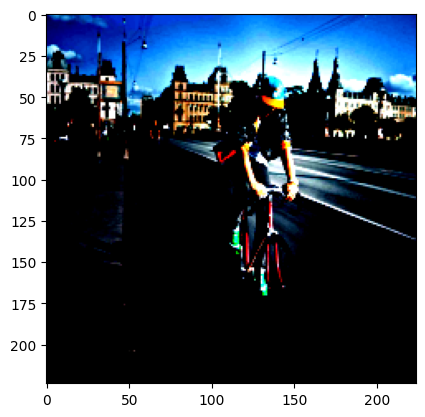

In [428]:
url = 'https://www.velotown.ru/files/news/1068/source.jpg?v=1558839675'
path = './image.jpg'
get_image_caption(path)

In [429]:
output = model.forward(image_vectors, target_sequences)
output[1:].shape

torch.Size([11, 10, 6471])

In [430]:
output_dim = output.shape[-1]
output_dim, output.shape

(6471, torch.Size([12, 10, 6471]))

In [432]:
lr = 0.001
emb_dim = 128
hid_dim = 256
n_layers = 1
# dropout = 0.3
num_epochs = 50
batch_size = 128

clip = 1
seq_len = 12

vocab_size = tokenizer.get_vocab_size()
cnn_feature_dim = 4096

device = 'cuda' if torch.cuda.is_available() else 'cpu'
PAD_IDX = tokenizer.token_to_id('[PAD]')

Инициализируем модель

In [433]:
encoder = ImageEncoder(hid_dim, n_layers, cnn_feature_dim).to(device)
decoder = LSTM_Caption(emb_dim, hid_dim, n_layers, cnn_feature_dim, vocab_size).to(device)
model = ImageCaption(encoder, decoder, seq_len).to(device)

Инициализиуем оптимизатор и лосс функцию. 

Лосс функции нужно указать ID токена паддинга, чтобы он не участвовал в обучении.

In [434]:
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

Напишем функцию, которая вычисляет метрику BLUE, будем наблюдать за данной метрикой в ходе обучения.

In [435]:
def BLEU(predicted_sequences, target_sequences):
    predict = torch.argmax(predicted_sequences, -1)
    # print(predicted_sequences.shape)
    # print(predict.shape[-1])
    # print(predict)
    
    sentences = []
    targets = []
    
    for i in range(predict.shape[-1]):
        
        sentence_ids = predict[:, i].tolist()
        
        sentence = tokenizer.decode(sentence_ids)
        
        target_ids = target_sequences[:,i].tolist()
        
        target = tokenizer.decode(target_ids)
        
        sentences.append([sentence])
        
        targets.append(target)
    
    return corpus_bleu(sentences, targets, smoothing_function = SmoothingFunction().method1)

Функция обучения

In [436]:
def train(model, dataloader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    bleu = 0
    
    for batch in dataloader:
        
        # print(batch)
        
        # [batch_size, cnn_features_dim]
        image_vectors = batch['image_vector'].squeeze().to(device)
        
        # [batch_size, seq_len]
        target_sequences = batch['caption'].to(device)
        
        print(target_sequences.shape)
        
        optimizer.zero_grad()
        
        # predicted_sequences - РАЗМЕРНОСТЬ [seq_len, batch_size, vocab_size]
        predicted_sequences = model.forward(image_vectors, target_sequences)
        
        # Транспонируем тензор (нужно привести в такой формат для корректного подсчета cross entropy loss)
        # target_sequences - РАЗМЕРНОСТЬ[seq_len, batch_size]
        target_sequences = target_sequences.transpose(0, 1)
        
        bleu += BLEU(predicted_sequences, target_sequences)

        # сделаем необходимые решейпы для подачи данных в функцию потерь, не будем учитывать первые токены описаний
        predict_dim = predicted_sequences.shape[-1]
        
        # predicted_sequences - РАЗМЕРНОСТЬ [(seq_len - 1) * batch_size, vocab_size]
        predicted_sequences = predicted_sequences[1:].view(-1, predict_dim).to(device)
        
        # target_sequences - РАЗМЕРНОСТЬ [(seq_len - 1) * batch_size]
        target_sequences = target_sequences[1:].reshape(-1)
        
        loss = criterion(predicted_sequences, target_sequences)
        
        loss.backward()
        
        # в RNN есть узкое место, это взрывающиеся градиенты, чтобы избежать числовой нестабильности, мы клипаем градиенты, если они большие
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        # print(epoch_loss)
        
    train_loss = round((epoch_loss / len(dataloader)), 3)
    bleu_mean = round((bleu / len(dataloader)), 3) * 100
    
    return train_loss, bleu_mean

In [437]:
def evaluate(model, dataloader, criterion):
    
    model.eval()
    epoch_loss = 0.
    bleu = 0.
    
    with torch.no_grad():
        
        for batch in dataloader:

            # [batch_size, cnn_features_dim]
            image_vectors = batch['image_vector'].squeeze().to(device)

            # [batch_size, seq_len]
            target_sequences = batch['caption'].to(device)

            # predicted_sequences - РАЗМЕРНОСТЬ [seq_len, batch_size, vocab_size]
            predicted_sequences = model.forward(image_vectors, target_sequences)

            # Транспонируем тензор (нужно привести в такой формат для корректного подсчета cross entropy loss)
            # target_sequences - РАЗМЕРНОСТЬ[seq_len, batch_size]
            target_sequences = target_sequences.transpose(0, 1)

            bleu += BLEU(predicted_sequences, target_sequences)

            # сделаем необходимые решейпы для подачи данных в функцию потерь, не будем учитывать первые токены описаний
            predict_dim = predicted_sequences.shape[-1]

            # predicted_sequences - РАЗМЕРНОСТЬ [(seq_len - 1) * batch_size, vocab_size]
            predicted_sequences = predicted_sequences[1:].view(-1, predict_dim).to(device)

            # target_sequences - РАЗМЕРНОСТЬ [(seq_len - 1) * batch_size]
            target_sequences = target_sequences[1:].reshape(-1)

            loss = criterion(predicted_sequences, target_sequences)

            epoch_loss += loss.item()
        
    valid_loss = round((epoch_loss / len(dataloader)), 3)
    bleu_mean = round((bleu / len(dataloader)), 3) * 100
    
    return valid_loss, bleu_mean

In [438]:
# train(model, train_loader, optimizer, criterion, clip)
# torch.save(model.state_dict(), 'imgcap.pth')

In [439]:
# evaluate(model, val_dl, criterion)

In [440]:
train_data = CustomDataset(images = train_images,
                  captions = train_captions,
                  tokenizer = tokenizer)

train_data = filter_dataset(train_data)

val_data = CustomDataset(images = val_images,
                  captions = val_captions,
                  tokenizer = tokenizer)

val_data = filter_dataset(val_data)

In [ ]:
len(train_data)

In [108]:
# формирование батчей 
# batch -> list(batch_size x (tensor, annotation))

train_loader = DataLoader(train_data, 
                          batch_size = batch_size,
                          shuffle = False,           # не перемешиваем картинки меду собой в батче
                          drop_last = True           # удаляем последний пакет данных, если его размер меньше указанного
                         )
val_loader = DataLoader(val_data, 
                        batch_size = batch_size,
                        shuffle = False,           # не перемешиваем картинки меду собой в батче
                        drop_last = True           # удаляем последний пакет данных, если его размер меньше указанного
                        )
len(train_loader), len(val_loader)

(924, 39)

In [109]:
best_bleu = 20
for epoch in tqdm(range(num_epochs)):
    
    train_loss, train_bleu_mean = train(model, train_loader, optimizer, criterion, clip)
    val_loss, val_bleu_mean = evaluate(model, val_loader, criterion)
    
    print(f'Epoch: {epoch + 1} \n Train loss: {train_loss} \n Train bleu: {train_bleu_mean} \n\n Val loss: {val_loss} \n Val bleu: {val_bleu_mean}')
    
    # сохраним модель модель с лучшей метрикой BLEU
    if best_bleu < train_bleu_mean:
        best_bleu = train_bleu_mean
        torch.save(model.state_dict(), 'imgcap.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])
torch.Size([128, 17])


  0%|          | 0/20 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [72]:
# Создайте экземпляр модели
# Загрузите веса модели из файла
model.load_state_dict(torch.load('imgcap.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


a man on a street with a street . 

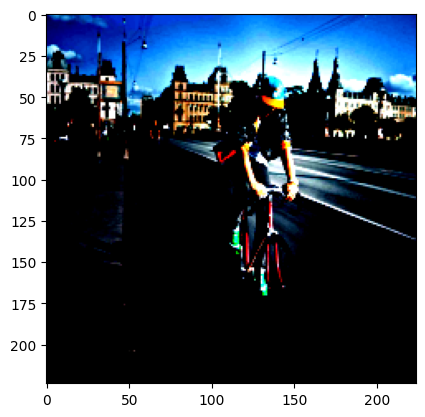

In [73]:
url = 'https://www.velotown.ru/files/news/1068/source.jpg?v=1558839675'
path = './image.jpg'
get_image_caption(path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


a man is on a man on a street . 

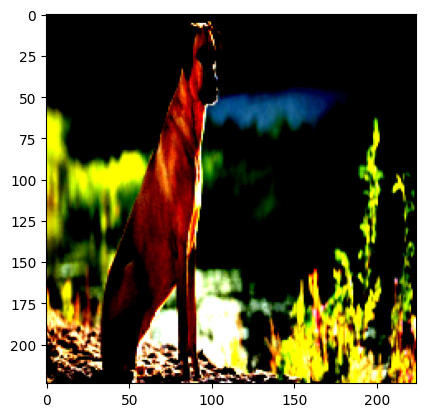

In [74]:
path = './dog.jpg'
get_image_caption(path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


a man is on a street with a man . 

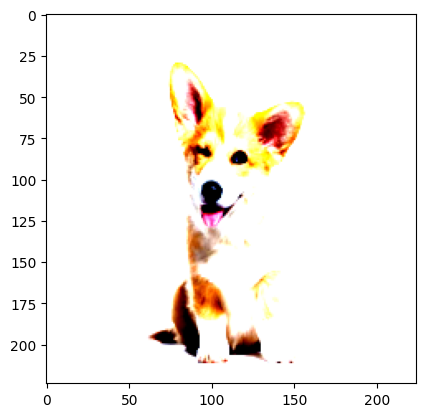

In [75]:
path = './dog1.jpg'
get_image_caption(path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


a man is on a street with a man . 

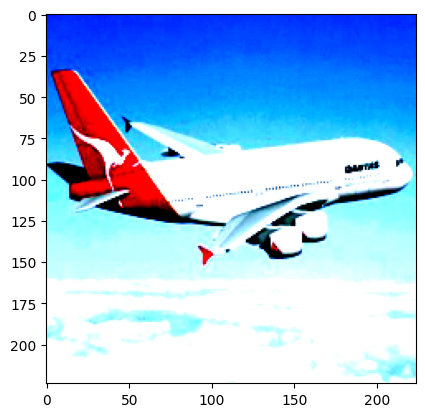

In [92]:
path = './plane.jpg'
get_image_caption(path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


a man is on a street with a man . 

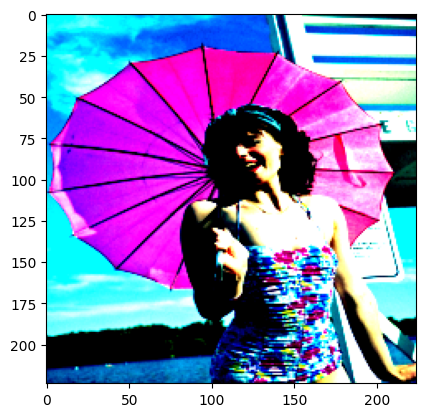

In [76]:
path = './000000000036.jpg'
get_image_caption(path)